Bayesian GPLVM
--
This notebook shows how to use the Bayesian GPLVM model.

In [1]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)

### Data
Install the oil dataset.

In [2]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Number of points X Number of dimensions (100, 12)


'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using an two-dimensional RBF kernel.

In [3]:
Q = 4
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
k = ekernels.RBF(Q, ARD=True)
m = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01
_=m.optimize()

### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

kern.variance transform:+ve prior:None
[ 0.7581384]
kern.lengthscales transform:+ve prior:None
[   4.00041544    1.53760347    3.03697195  167.06899255]
[ 0.21765525  0.56627827  0.28670381  0.00521169]


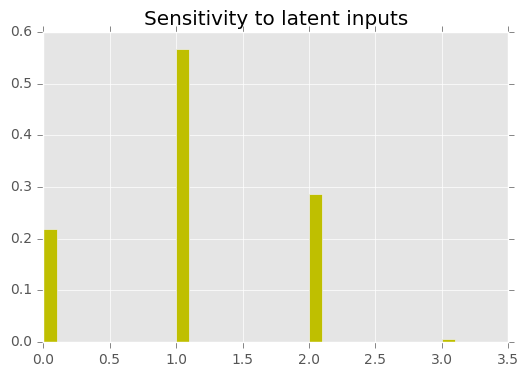

In [4]:
sens = np.sqrt(m.kern.variance.value)/m.kern.lengthscales.value
print(m.kern)
print(sens)
fig, ax = plt.subplots()
ax.bar(np.arange(Q) , sens, 0.1, color='y')
ax.set_title('Sensitivity to latent inputs')

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

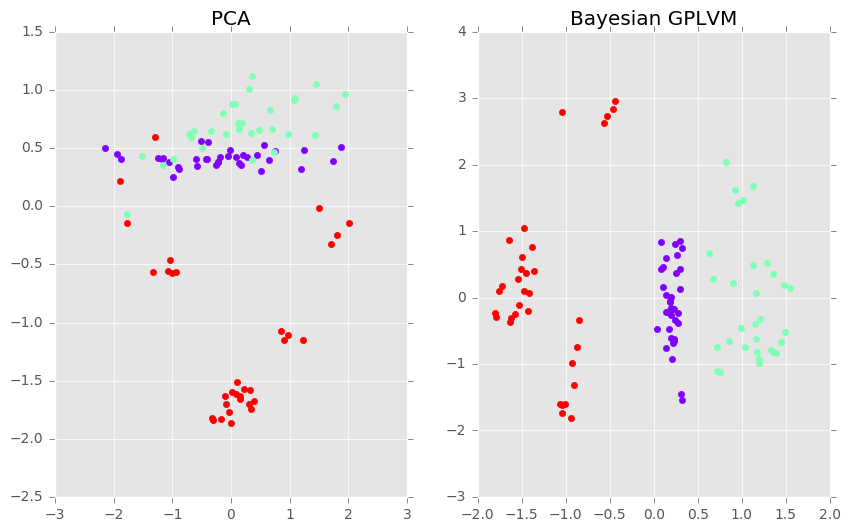

In [5]:
XPCAplot = GPflow.gplvm.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,2, figsize=(10,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(m.X_mean.value[labels==i,1], m.X_mean.value[labels==i,2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
    